## Outline:

- Naive Bayes with Iris dataset with real-valued features (as opposed to binary valued in class)
  - Ask to complete code in certain portions
  - Give wrong code (prior calculation) and ask to correct it
  - Ask to perform data analysis with size of training set for different classifiers
- Logistic regression with real valued features. 
  - implementing costfunction and gradient descent from scratch
  - Visualizing learned boundary 
- Designing, visualizing, and testing classification metrics from scratch (AUC, ROC, Acc, IOU etc.)


In [15]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
iris = load_iris()
X, y = iris.data, iris.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# calculate class priors from train data
priors = (np.bincount(y_train)/y_train.size).reshape(-1,1)

# calculate per class data likelihoods
feature_means = np.zeros((priors.size,1,X_train.shape[1]))
feature_std = np.zeros((priors.size,1,X_train.shape[1]))

for i in range(priors.size):
    feature_means[i] = np.mean(X_train[y_train == i], axis=0).reshape(1,-1)
    feature_std[i] = np.std(X_train[y_train == i], axis=0).reshape(1,-1)

# define gaussian kernel
def gaussian(x, mean, std):
    """Computes gaussian probabilty of a feature given the mean and std"""
    
    return 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/std)**2)


# compute per class posteriors for test data
posteriors = np.zeros((y_test.size, priors.size))

for i in range(priors.size):
    posteriors[:, i] = np.exp(np.sum(np.log(gaussian(X_test, feature_means[i], feature_std[i]) + 1e-4), axis=1) + np.log(priors[i]))

# perform inference
posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
y_pred = np.argmax(posteriors, axis=1)

print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))


Accuracy Score: 0.938


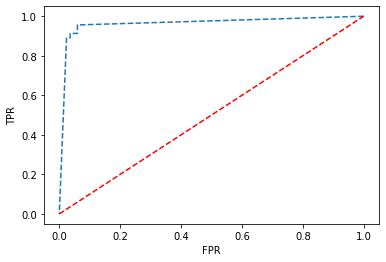

In [127]:
# designing classification metrics by hand
import numpy as np

class_num = 2  # can't be zero
probs = posteriors[:,class_num].reshape(-1,1)
y_test_1 = np.zeros(y_test.shape).astype(int)
y_test_1[y_test==class_num] = 1

# generate ROC
thresholds = np.linspace(0,1,100)
mask = (probs > thresholds)*1 
TPR = np.sum(mask * y_test_1.reshape(-1,1), axis=0) / y_test_1.sum()
FPR = np.sum(mask * (1-y_test_1.reshape(-1,1)), axis=0) / (1 - y_test_1).sum()

# plot ROC
import matplotlib.pyplot as plt
plt.plot(FPR, TPR, linestyle='--'), plt.xlabel('FPR'), plt.plot([0,1],[0,1], linestyle='--', color='red'), plt.ylabel('TPR')
plt.show()

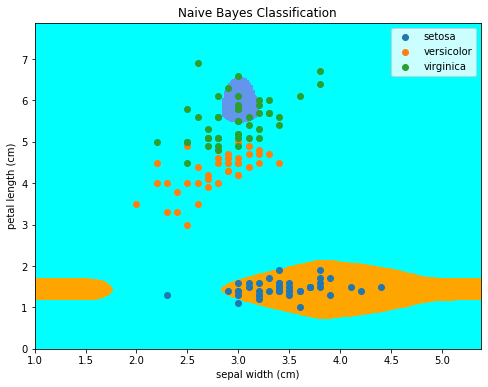

In [57]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


h = 0.02 
feature_1 = 1
feature_2 = 2


# plotting and visualizing the decision boundary
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])

x_min, x_max = X_test[:, feature_1].min() - 1, X_test[:, feature_1].max() + 1
y_min, y_max = X_test[:, feature_2].min() - 1, X_test[:, feature_2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

X_test_n = np.concatenate((np.ones((xx.size,1)), xx.reshape(-1,1),yy.reshape(-1,1), np.ones((xx.size,1))), axis=1)

def bayes_predict(X_test, feature_means, feature_std, priors):
    """Computes naive bayes class predictions for a data"""
    
    # compute per class posteriors for test data
    posteriors = np.zeros((X_test.shape[0], priors.size))

    for i in range(priors.size):
        posteriors[:, i] = np.exp(np.sum(np.log(gaussian(X_test, feature_means[i], feature_std[i]) + 1e-4), axis=1) + np.log(priors[i]))

    # perform inference
    posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
    y_pred = np.argmax(posteriors, axis=1)
    
    return y_pred

y_pred_n = bayes_predict(X_test_n, feature_means, feature_std, priors)

y_pred_n = y_pred_n.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, y_pred_n, cmap=cmap_light)

# Plot also the training points
for class_num in np.unique(y_test):
        ax.scatter(X_test[:,1][y_test==class_num], X_test[:,2][y_test==class_num], label = iris.target_names[class_num])


plt.title("Naive Bayes Classification")
plt.xlabel(iris.feature_names[feature_1])
plt.ylabel(iris.feature_names[feature_2])
plt.legend()
plt.show()

In [157]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# append 1 to X for bias
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# initialize theta vector randomly
theta = np.random.randn(X_train.shape[1],1)

# define logistic regression cost function
def logit_cost_func(theta, features, targets):
    """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets"""
    
    return np.sum(targets.reshape(-1,1) * features.dot(theta) - np.log(1 + np.exp(features.dot(theta))))
    

# define gradient function
def logit_grad(theta, features, targets):
    """Function computes the gradient of the logistic regression given the theta vector, the feature tensor, and corresponding targets"""
    
    return features.T.dot(targets.reshape(-1,1) - 1 / (1 + np.exp(features.dot(theta))))


# define gradient descent attributes
step = 5 
epochs = 20

# start training
for epoch in range(epochs):
    print("Epoch: [%d/%d]"%(epoch, epochs), "| Function value: %.2f" %logit_cost_func(theta, X_train, y_train))
    theta = theta - step * logit_grad(theta, X_train, y_train)

# perform inference
y_pred = np.zeros(y_test.shape).reshape(-1,1).astype(int)
probs = 1 / (1 + np.exp(X_test.dot(theta)))
y_pred[probs > 0.5] = 1

# compute accuracy
print("\nAccuracy: %.2f"%accuracy_score(y_test.ravel(), y_pred.ravel()))

Epoch: [0/20] | Function value: -11.36
Epoch: [1/20] | Function value: -203.35
Epoch: [2/20] | Function value: -662.62
Epoch: [3/20] | Function value: -1192.94
Epoch: [4/20] | Function value: -1231.57
Epoch: [5/20] | Function value: -1021.15
Epoch: [6/20] | Function value: -1800.53
Epoch: [7/20] | Function value: -1050.95
Epoch: [8/20] | Function value: -1087.89
Epoch: [9/20] | Function value: -1027.31
Epoch: [10/20] | Function value: -1065.57
Epoch: [11/20] | Function value: -1063.48
Epoch: [12/20] | Function value: -1062.78
Epoch: [13/20] | Function value: -1062.30
Epoch: [14/20] | Function value: -1061.93
Epoch: [15/20] | Function value: -1061.63
Epoch: [16/20] | Function value: -1061.37
Epoch: [17/20] | Function value: -1061.15
Epoch: [18/20] | Function value: -1060.95
Epoch: [19/20] | Function value: -1060.78

Accuracy: 0.88


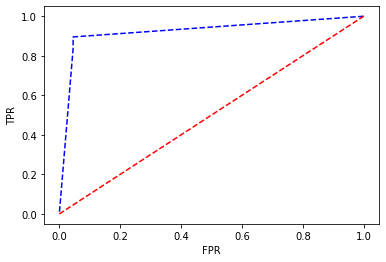

In [129]:
# designing classification metrics by hand
import numpy as np

# generate ROC
thresholds = np.linspace(0,1,100)
mask = (probs > thresholds)*1 
TPR = np.sum(mask * y_test.reshape(-1,1), axis=0) / y_test.sum()
FPR = np.sum(mask * (1-y_test.reshape(-1,1)), axis=0) / (1 - y_test).sum()

# plot ROC
import matplotlib.pyplot as plt
plt.plot(FPR, TPR, linestyle='--', color='blue'), plt.plot([0,1],[0,1], linestyle='--', color='red'), plt.xlabel('FPR'), plt.ylabel('TPR')
plt.show()



# Using Classes to set up Models
---


Epoch: [0/20] | Function value: -14.59
Epoch: [1/20] | Function value: -53.44
Epoch: [2/20] | Function value: -174.11
Epoch: [3/20] | Function value: -48.35
Epoch: [4/20] | Function value: -96.39
Epoch: [5/20] | Function value: -111.95
Epoch: [6/20] | Function value: -161.04
Epoch: [7/20] | Function value: -104.00
Epoch: [8/20] | Function value: -116.75
Epoch: [9/20] | Function value: -107.07
Epoch: [10/20] | Function value: -114.91
Epoch: [11/20] | Function value: -107.96
Epoch: [12/20] | Function value: -113.92
Epoch: [13/20] | Function value: -110.29
Epoch: [14/20] | Function value: -112.65
Epoch: [15/20] | Function value: -112.19
Epoch: [16/20] | Function value: -113.01
Epoch: [17/20] | Function value: -113.35
Epoch: [18/20] | Function value: -113.86
Epoch: [19/20] | Function value: -114.30

True Positive Rate: 0.94
False Positive Rate: 0.05


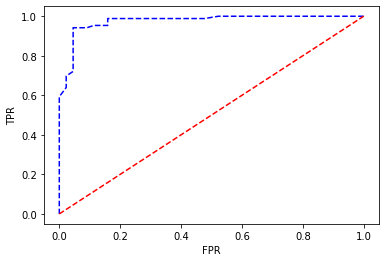

In [8]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

class MyLogisticRegression:    
    def __init__(self, X, y):       
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y
        self.theta  = np.random.randn(self.X.shape[1],1)
        
    # define logistic regression cost function
    def logit_cost_func(self, theta, features, targets):
        """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets"""
    
        return np.sum(targets.reshape(-1,1) * features.dot(theta) - np.log(1 + np.exp(features.dot(theta))))
    

    # define gradient function
    def logit_grad(self, theta, features, targets):
        """Function computes the gradient of the logistic regression given the theta vector, the feature tensor, and corresponding targets"""
    
        return features.T.dot(targets.reshape(-1,1) - 1 / (1 + np.exp(features.dot(theta))))
    
    
    def normalize_data(self, X):
        X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))
        return X
    
    def fit(self, num_epochs=20, step=2):
        for epoch in range(num_epochs):
            print("Epoch: [%d/%d]"%(epoch, num_epochs), "| Function value: %.2f" % self.logit_cost_func(self.theta, self.X, self.y))
            self.theta = self.theta - step * self.logit_grad(self.theta, self.X, self.y) / self.X.shape[0]
            
            
    def predict(self, X):        
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        y_pred = np.zeros(X.shape[0]).reshape(-1,1).astype(int)
        probs = 1 / (1 + np.exp(X.dot(self.theta)))
        y_pred[probs > 0.5] = 1
        
        return y_pred, probs
 

def roc(probs, y_test):
    """Function returns TPR and FPR given a vector of probabilities and another 
    for ground-truth predictions"""
    
    thresholds = np.linspace(0,1,100)
    mask = (probs > thresholds)*1 
    TPR = np.sum(mask * y_test.reshape(-1,1), axis=0) / y_test.sum()
    FPR = np.sum(mask * (1-y_test.reshape(-1,1)), axis=0) / (1 - y_test).sum()
    
    return TPR, FPR


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# train model and predict on test data
model =  MyLogisticRegression(X_train, y_train)
model.fit(num_epochs = 20, step=10)
y_pred, probs = model.predict(X_test)

# compute accuracy
print("\nTrue Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * y_test.reshape(-1,1))/np.sum(y_test)))
print("False Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * (1 - y_test).reshape(-1,1))/np.sum(1 - y_test)))

# plot ROC
TPR, FPR = roc(probs, y_test)
plt.plot(FPR, TPR, linestyle='--', color='blue') 
plt.plot([0,1],[0,1], linestyle='--', color='red') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


# Effect of Training Set Size on ROC 

In [9]:
# implement naive bayes class

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyNaiveBayes:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    
    def gaussian(self, x, mean, std):
        return 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/std)**2)
    
    
    def fit(self):
        # calculate class priors from train data
        self.priors = (np.bincount(self.y_train)/self.y_train.size).reshape(-1,1)
        
        # calculate per class data likelihoods
        self.feature_means = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        self.feature_std = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        
        for i in range(self.priors.size):
            self.feature_means[i] = np.mean(self.X_train[self.y_train == i], axis=0).reshape(1,-1)
            self.feature_std[i] = np.std(self.X_train[self.y_train == i], axis=0).reshape(1,-1)

    
    def predict(self, X_test):
        # compute per class posteriors for test data
        posteriors = np.zeros((X_test.shape[0], self.priors.size))

        for i in range(self.priors.size):
            posteriors[:, i] = np.exp(np.sum(np.log(self.gaussian(X_test, self.feature_means[i], self.feature_std[i]) + 1e-4), axis=1) + np.log(self.priors[i]))

        # perform inference
        posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
        y_pred = np.argmax(posteriors, axis=1)
        
        return y_pred, posteriors


# define train and test sizes
N_train = 10
N_test = 150 - N_train

# load data
iris = load_iris()
X, y = iris.data, iris.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))    

Accuracy Score: 0.821


Epoch: [0/20] | Function value: -3.39
Epoch: [1/20] | Function value: -10.66
Epoch: [2/20] | Function value: -13.27
Epoch: [3/20] | Function value: -13.87
Epoch: [4/20] | Function value: -16.87
Epoch: [5/20] | Function value: -15.34
Epoch: [6/20] | Function value: -19.28
Epoch: [7/20] | Function value: -18.65
Epoch: [8/20] | Function value: -19.68
Epoch: [9/20] | Function value: -20.12
Epoch: [10/20] | Function value: -20.50
Epoch: [11/20] | Function value: -20.86
Epoch: [12/20] | Function value: -21.20
Epoch: [13/20] | Function value: -21.51
Epoch: [14/20] | Function value: -21.81
Epoch: [15/20] | Function value: -22.08
Epoch: [16/20] | Function value: -22.35
Epoch: [17/20] | Function value: -22.60
Epoch: [18/20] | Function value: -22.84
Epoch: [19/20] | Function value: -23.07

True Positive Rate: 0.99
False Positive Rate: 0.98
Epoch: [0/20] | Function value: -36.19
Epoch: [1/20] | Function value: -58.83
Epoch: [2/20] | Function value: -209.24
Epoch: [3/20] | Function value: -231.22
E

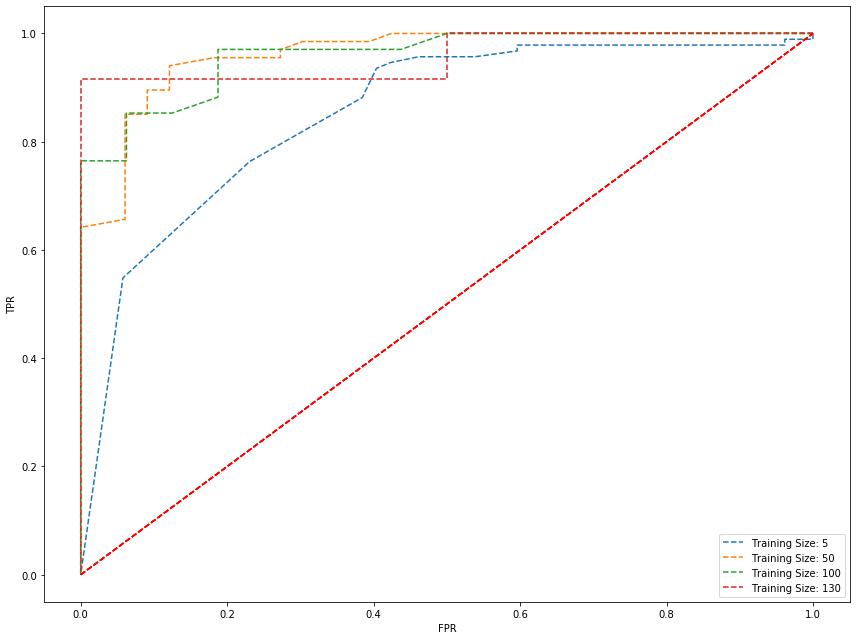

In [14]:
training_set_sizes = [5, 50, 100, 130]

fig, ax = plt.subplots(figsize=(12,9))

for train_size in training_set_sizes:
    
    # define train and test sizes
    N_train = train_size
    N_test = 150 - N_train

    # load data
    cancer = load_breast_cancer()
    X, y = cancer.data, cancer.target

    # Normalize X
    X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

    # train model and predict on test data
    model =  MyLogisticRegression(X_train, y_train)
    model.fit(num_epochs = 20, step=10)
    y_pred, probs = model.predict(X_test)

    # compute accuracy
    print("\nTrue Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * y_test.reshape(-1,1))/np.sum(y_test)))
    print("False Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * (1 - y_test).reshape(-1,1))/np.sum(1 - y_test)))

    # plot ROC
    TPR, FPR = roc(probs, y_test)
    ax.plot(FPR, TPR, linestyle='--', label='Training Size: %d' % N_train) 
    ax.plot([0,1],[0,1], linestyle='--', color='red') 
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

plt.legend()
plt.tight_layout()
plt.show()    

In [32]:
# Use sklearn

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# append 1 to X for bias
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# set up model
model = LogisticRegression()

# train and test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print accuracy
print("Accuracy: %.2f"%accuracy_score(y_test.ravel(), y_pred.ravel()))


Accuracy: 0.88
